In [1]:
# Importation librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import warnings

# Masque avertissement quand importation fichiers "xlsx"
warnings.filterwarnings('ignore', category = UserWarning, module = 'openpyxl')

# Augmentation du nombre de colonnes affichées dans les DataFrame
pd.set_option('display.max_columns', 50)

<img src='./images/logo-bottleneck-sans-fond.png' width=240px />

Dans le cadre de ce projet, nous sommes *Data Analyst freelance* en mission chez BottleNeck qui est un marchand de vin. L'objectif est d'étudier les ventes de la boutique en ligne, mais pour cela, il faudra au préalable nettoyer et rapprocher les données mises à notre disposition.

## Sommaire<a id='0'></a>

* [Préparation des données source](#1)
    * [Export de l'ERP](#1-1)
    * [Fichier de liaison](#1-2)
    * [Export du CMS](#1-3)
* [Rapprochement des exports](#2)
* [Analyse des ventes en ligne](#3)
    * [Chiffre d'affaires par produit](#3-1)
    * [Chiffre d'affaires total](#3-2)
* [Analyse des prix des produits](#4)
    * [Distribution empirique des prix](#4-1)
    * [Mesures de tendance centrale](#4-2)
    * [Mesures de dispersion](#4-3)
    * [Conclusion](#4-4)
* [Pour aller plus loin](#5)
    * [Mesures de forme](#5-1)
    * [Mesures de concentration](#5-2)

## Préparation des données source<a id='1'></a>

Cette première partie sera consacrée au traitement de chaque fichier Excel:
* chargement des données dans un *DataFrame*;
* vérification de l'importation;
* suppression des variables inutiles;
* vérification du type des données;
* vérification des valeurs manquantes et/ou des doublons.

### Export de l'ERP<a id='1-1'></a>

In [2]:
df_erp = pd.read_excel('./datasets/erp.xlsx')

In [3]:
df_erp.head(3)

,product_id,onsale_web,price,stock_quantity,stock_status
0,3847,1,24.2,0,outofstock
1,3849,1,34.3,0,outofstock
2,3850,1,20.8,0,outofstock


In [4]:
df_erp.shape

(825, 5)

Les données de l'ERP contiennent 825 produits renseignés sur 5 variables nous donnant des informations sur leur code, leur disponibilité à la vente en ligne, leur prix et l'état de leur stock.

In [5]:
df_erp.dtypes

product_id          int64
onsale_web          int64
price             float64
stock_quantity      int64
stock_status       object
dtype: object

La variable "product_id" est qualitative, nous allons la convertir en objet.<br>
La variable "onsale_web" est booléenne. Nous allons la convertir en vérifiant avant qu'elle ne comprenne bien que les valeurs 0 ou 1.

In [6]:
# Vérification valeurs présentes dans "onsale_web"
verification_valeurs = df_erp['onsale_web'].isin([0, 1]).all()

print(
    f'La variable \"onsale_web\" ne contient bien que les valeurs 0 ou 1 : {verification_valeurs}.')

del verification_valeurs

La variable "onsale_web" ne contient bien que les valeurs 0 ou 1 : True.


In [7]:
df_erp['product_id'] = df_erp['product_id'].astype(object)
df_erp['onsale_web'] = df_erp['onsale_web'].astype(bool)

In [8]:
df_erp.isna().sum()

product_id        0
onsale_web        0
price             0
stock_quantity    0
stock_status      0
dtype: int64

Il n'y a pas de valeurs manquantes, on passe aux doublons.

In [9]:
# Test des doublons sur le code produit
test_doublons = df_erp.duplicated(subset=['product_id']).sum()

print(f'Il y a {test_doublons} doublons dans les codes produits.')

del test_doublons

Il y a 0 doublons dans les codes produits.


### Fichier de liaison<a id='1-2'></a>

In [10]:
df_liaison = pd.read_excel('./datasets/liaison.xlsx')

In [11]:
df_liaison.head(3)

,product_id,id_web
0,3847,15298
1,3849,15296
2,3850,15300


In [12]:
df_liaison.shape

(825, 2)

Les données du fichier de liaison contiennent également 825 produits et 2 variables:
* "product_id": le code du produit issu de l'ERP;
* "id_web": le code du produit issu du CMS.

Nous savons que "id_web" correspond en fait au SKU du CMS donc nous allons tout de suite renommer la colonne.

In [13]:
df_liaison = df_liaison.rename(columns = {'id_web':'sku'})

In [14]:
df_liaison.dtypes

product_id     int64
sku           object
dtype: object

La variable "product_id" est qualitative, nous la convertissons en objet.

In [15]:
df_liaison['product_id'] = df_liaison['product_id'].astype(object)

In [16]:
df_liaison.isna().sum()

product_id     0
sku           91
dtype: int64

Il manque 91 valeurs pour "sku". Les produits concernés ne pourront pas être rapprochés de leur(s) vente(s), il est donc inutile de les conserver.

In [17]:
df_liaison = df_liaison.dropna().reset_index(drop=True)

Pour finir, nous nous assurons que les codes "product_id" et "sku" ne contiennent pas de doublons.

In [18]:
# Test des doublons sur le code produit et le SKU
test_doublons = df_liaison.duplicated(subset=['product_id', 'sku']).sum()

print(f'Il y a {test_doublons} doublons dans les codes produits et les SKU.')

del test_doublons

Il y a 0 doublons dans les codes produits et les SKU.


### Export du CMS<a id='1-3'></a>

In [19]:
df_web = pd.read_excel('./datasets/web.xlsx')

In [20]:
df_web.head(3)

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,post_date_gmt,post_content,post_title,post_excerpt,post_status,comment_status,ping_status,post_password,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,bon-cadeau-25-euros,0,0,0,0.0,10.0,taxable,NaN,1.0,2018-06-01 13:53:46,2018-06-01 11:53:46,NaN,Bon cadeau de 25€,"<span style=""color: #a85253;""><strong>Parlons ...",publish,closed,closed,NaN,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1,15298,0,0,0,0.0,6.0,taxable,NaN,2.0,2018-02-08 12:58:52,2018-02-08 11:58:52,NaN,Pierre Jean Villa Saint-Joseph Préface 2018,"Il exhale un nez subtil, racé avec du poivre f...",publish,closed,closed,NaN,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
2,15296,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 13:49:41,2018-02-08 12:49:41,NaN,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017,Les vieilles vignes lui apportent une rare pro...,publish,closed,closed,NaN,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


In [21]:
df_web.shape

(1513, 28)

Les données du CMS contiennent 1513 produits avec 28 variables:
* Le nombre de produits disponibles en ligne est largement supérieur au nombre de produits dans le *DataFrame* `df_erp`.
* Les variables sont nombreuses, mais beaucoup semblent vides ou ne semblent comporter que des 0.<br>

In [22]:
df_web.dtypes

sku                              object
virtual                           int64
downloadable                      int64
rating_count                      int64
average_rating                  float64
total_sales                     float64
tax_status                       object
tax_class                       float64
post_author                     float64
post_date                datetime64[ns]
post_date_gmt            datetime64[ns]
post_content                    float64
post_title                       object
post_excerpt                     object
post_status                      object
comment_status                   object
ping_status                      object
post_password                   float64
post_name                        object
post_modified            datetime64[ns]
post_modified_gmt        datetime64[ns]
post_content_filtered           float64
post_parent                     float64
guid                             object
menu_order                      float64


Il y a plusieurs variables dont on ne sait pas à quoi elles correspondent exactement et il est difficile de savoir de quel type elles devraient être. Nous allons donc étudier la possibilité d'en supprimer quelques-unes. Utilisons la méthode `.describe()` qui va nous donner des informations sur les variables définies comme quantitatives dans le *DataFrame*.

In [23]:
df_web.describe()

,virtual,downloadable,rating_count,average_rating,total_sales,tax_class,post_author,post_content,post_password,post_content_filtered,post_parent,menu_order,comment_count
count,1513.0,1513.0,1513.0,1430.0,1430.000000,0.0,1430.000000,0.0,0.0,0.0,1430.0,1430.0,1430.0
mean,0.0,0.0,0.0,0.0,4.006993,NaN,1.998601,NaN,NaN,NaN,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,8.510559,NaN,0.037385,NaN,NaN,NaN,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.000000,NaN,1.000000,NaN,NaN,NaN,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.000000,NaN,2.000000,NaN,NaN,NaN,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,1.000000,NaN,2.000000,NaN,NaN,NaN,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,4.000000,NaN,2.000000,NaN,NaN,NaN,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,96.000000,NaN,2.000000,NaN,NaN,NaN,0.0,0.0,0.0


Plusieurs variables ont pour seule valeur 0 et d'autres n'ont aucune valeur. Toutes ces variables peuvent donc être supprimées sans risque.

In [24]:
# Suppression colonnes dont toutes les lignes sont égales à 0
df_web = df_web.drop(df_web.loc[:, (df_web == 0).all(axis='rows')]
                     , axis='columns')

# Suppression colonnes dont toutes les lignes sont vides
df_web = df_web.dropna(axis='columns', how='all')

df_web.shape

(1513, 21)

Le nombre de variables est passé de 28 à 21, voyons ce que cela donne si on utilise à nouveau `.describe()`.

In [25]:
df_web.describe()

,average_rating,total_sales,post_author,post_parent,menu_order,comment_count
count,1430.0,1430.000000,1430.000000,1430.0,1430.0,1430.0
mean,0.0,4.006993,1.998601,0.0,0.0,0.0
std,0.0,8.510559,0.037385,0.0,0.0,0.0
min,0.0,0.000000,1.000000,0.0,0.0,0.0
25%,0.0,0.000000,2.000000,0.0,0.0,0.0
50%,0.0,1.000000,2.000000,0.0,0.0,0.0
75%,0.0,4.000000,2.000000,0.0,0.0,0.0
max,0.0,96.000000,2.000000,0.0,0.0,0.0


4 colonnes comportent 1430 fois la valeur 0. On devine que les valeurs restantes sont manquantes et que c'est pour cela qu'elles n'ont pas été supprimées. Vérifions ce raisonnement en affichant le nombre de fois où chaque valeur est présente.

In [26]:
# Décompte valeurs des 4 colonnes
df_web[['average_rating', 'post_parent', 'menu_order', 'comment_count']
       ].value_counts(dropna=False)

average_rating  post_parent  menu_order  comment_count
0.0             0.0          0.0         0.0              1430
NaN             NaN          NaN         NaN                83
dtype: int64

Notre intuition est confirmée. Nous pouvons supprimer ces colonnes puis afficher de nouveau le type des données.

In [27]:
df_web = df_web.drop(['average_rating', 'post_parent',
                     'menu_order', 'comment_count'], axis='columns')

df_web.dtypes

sku                          object
total_sales                 float64
tax_status                   object
post_author                 float64
post_date            datetime64[ns]
post_date_gmt        datetime64[ns]
post_title                   object
post_excerpt                 object
post_status                  object
comment_status               object
ping_status                  object
post_name                    object
post_modified        datetime64[ns]
post_modified_gmt    datetime64[ns]
guid                         object
post_type                    object
post_mime_type               object
dtype: object

Tout semble correct à l'exception de "post_author" qui est une variable qualitative que nous allons convertir en objet.

In [28]:
df_web['post_author'] = df_web['post_author'].astype(object)

Nous avons commencé à travailler sur les colonnes, vérifions maintenant les lignes.

In [29]:
df_web.isna().sum()

sku                   85
total_sales           83
tax_status           797
post_author           83
post_date             83
post_date_gmt         83
post_title            83
post_excerpt         797
post_status           83
comment_status        83
ping_status           83
post_name             83
post_modified         83
post_modified_gmt     83
guid                  83
post_type             83
post_mime_type       799
dtype: int64

83 lignes sont entièrement vides et peuvent être supprimées. On notera qu'en plus de ces lignes, deux autres n'ont pas de "sku".

In [30]:
df_web = df_web.dropna(how='all', axis='rows').reset_index(drop=True)

Quelles sont les deux lignes sans "sku"?

In [31]:
df_web.loc[df_web['sku'].isna() & ~df_web['total_sales'].isna()]

,sku,total_sales,tax_status,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,guid,post_type,post_mime_type
448,NaN,0.0,taxable,2.0,2018-07-31 12:07:23,2018-07-31 10:07:23,Pierre Jean Villa Côte Rôtie Fongeant 2017,"Fongeant 2017 explose sur un fruit brillant, p...",publish,closed,closed,pierre-jean-villa-cote-rotie-fongeant-2017,2019-11-02 13:24:15,2019-11-02 12:24:15,https://www.bottle-neck.fr/?post_type=product&...,product,NaN
449,NaN,0.0,taxable,2.0,2018-08-08 11:23:43,2018-08-08 09:23:43,Pierre Jean Villa Condrieu Jardin Suspendu 2018,"<span id=""u1194-83"">Le nez séduit par ses parf...",publish,closed,closed,pierre-jean-villa-condrieu-suspendu-2018,2019-11-02 13:24:01,2019-11-02 12:24:01,https://www.bottle-neck.fr/?post_type=product&...,product,NaN


La variable "post_title" va nous aider à chercher si ces produits existe ailleurs dans notre jeu de données et si nous pourrions donc en déduire leur SKU.

In [32]:
df_web.loc[(df_web['post_title'].str.contains('^pierre.jean.villa.*fongeant.*2017', case=False)) |
           (df_web['post_title'].str.contains('^pierre.jean.villa.*condrieu.*2018', case=False)),
           ['sku', 'post_title']]

,sku,post_title
448,NaN,Pierre Jean Villa Côte Rôtie Fongeant 2017
449,NaN,Pierre Jean Villa Condrieu Jardin Suspendu 2018


Il n'y a pas d'autres résultats, nous pouvons aussi supprimer ces deux lignes.

In [33]:
df_web = df_web.dropna(subset=['sku'], axis='rows').reset_index(drop=True)

En ce qui concerne les doublons, nous savons déjà qu'il y en a car `df_web` compte bien plus de lignes que les autres *DataFrame*. Vérifions en quelle quantité ils sont présents.

In [34]:
taux_doublons_df_web = df_web['sku'].nunique() / df_web['sku'].size

print(f'{taux_doublons_df_web:.2%} des lignes du DataFrame sont des doublons.')

del taux_doublons_df_web

50.00% des lignes du DataFrame sont des doublons.


Chaque ligne produit est doublée. Il a surement une différence notable entre une ligne et son doublon qui nous permettra de supprimer les lignes inutiles. Pour cela, nous allons choisir une ligne aléatoirement, puis nous allons chercher son doublon et enfin  afficher les deux lignes.

In [35]:
# Sélection aléatoire d'une ligne
random_index = np.random.randint(0, len(df_liaison['product_id']))

# Sélection SKU à partir de l'index de la ligne aléatoire
random_sku = df_web['sku'].iloc[random_index]

# Affichage des deux lignes en doublons
df_web.loc[df_web['sku'] == random_sku]

,sku,total_sales,tax_status,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,guid,post_type,post_mime_type
478,16130,9.0,taxable,2.0,2018-10-09 15:22:19,2018-10-09 13:22:19,Decelle-Villa Meursault 2018,"De couleur Jaune paille brillante, le Meursaul...",publish,closed,closed,decelle-villa-meursault-2018,2020-08-26 11:25:02,2020-08-26 09:25:02,https://www.bottle-neck.fr/?post_type=product&...,product,NaN
1192,16130,9.0,NaN,2.0,2018-10-09 15:22:19,2018-10-09 13:22:19,Decelle-Villa Meursault 2018,NaN,publish,closed,closed,decelle-villa-meursault-2018,2020-08-26 11:25:02,2020-08-26 09:25:02,https://www.bottle-neck.fr/wp-content/uploads/...,attachment,image/jpeg


In [36]:
del random_index, random_sku

Quelques variables, dont "post_type", diffèrent. Cette dernière prend soit la valeur "product", soit la valeur "attachment". Nous n'allons conserver que les lignes "product". Malgré tout, par mesure de sécurité, vérifions si "post_type" ne prend pas d'autre(s) valeur(s).

In [37]:
df_web['post_type'].unique()

array(['product', 'attachment'], dtype=object)

La vérification est concluante, on peut supprimer les lignes.

In [38]:
df_web = df_web.loc[df_web['post_type'] != 'attachment'].copy()

Voyons à quoi ressemble maintenant le *DataFrame*.

In [39]:
df_web.head(3)

,sku,total_sales,tax_status,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,guid,post_type,post_mime_type
0,bon-cadeau-25-euros,10.0,taxable,1.0,2018-06-01 13:53:46,2018-06-01 11:53:46,Bon cadeau de 25€,"<span style=""color: #a85253;""><strong>Parlons ...",publish,closed,closed,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,https://www.bottle-neck.fr/?post_type=product&...,product,NaN
1,15298,6.0,taxable,2.0,2018-02-08 12:58:52,2018-02-08 11:58:52,Pierre Jean Villa Saint-Joseph Préface 2018,"Il exhale un nez subtil, racé avec du poivre f...",publish,closed,closed,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,https://www.bottle-neck.fr/?post_type=product&...,product,NaN
2,15296,0.0,taxable,2.0,2018-02-08 13:49:41,2018-02-08 12:49:41,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017,Les vieilles vignes lui apportent une rare pro...,publish,closed,closed,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,https://www.bottle-neck.fr/?post_type=product&...,product,NaN


Nous avons nettoyé les lignes, essayons de supprimer encore quelques colonnes inutiles.

In [40]:
df_web.nunique()

sku                  714
total_sales           41
tax_status             1
post_author            2
post_date            714
post_date_gmt        714
post_title           711
post_excerpt         677
post_status            1
comment_status         1
ping_status            1
post_name            714
post_modified        587
post_modified_gmt    587
guid                 714
post_type              1
post_mime_type         0
dtype: int64

On constate bien que l'on peut encore faire un peu de nettoyage:
* suppression des variables n'ayant qu'une valeur ou n'ayant que des valeurs manquantes;
* suppression des variables non pertinentes pour la suite de l'analyse;
* suppression des dates au format GMT (en doublon).

Enfin, nous allons modifier l'affichage des dates restantes en ne conservant que l'année, le mois et le jour.

In [41]:
# On ne conserve que les variables ayant au moins 2 valeurs différentes
df_web = df_web.loc[:, (df_web.nunique() > 2)].copy()

# Suppression colonnes non pertinentes
df_web = df_web.drop(['post_date_gmt', 'post_name', 'post_excerpt',
                     'post_modified_gmt', 'guid'], axis='columns')

# Modification format dates
df_web['post_date'] = df_web['post_date'].dt.normalize()
df_web['post_modified'] = df_web['post_modified'].dt.normalize()

Le nettoyage des données est terminé.

## Rapprochement des exports<a id='2'></a>

Le regroupement des données va être effectué dans un nouveau *DataFrame* que nous appellerons `df_final`. Cela va se passer en quatre étapes:
* regroupement des données de l'ERP avec le fichier de liaison;
* vérification et nettoyage du premier regroupement;
* regroupement du *DataFrame* obtenu avec les données du CMS;
* vérification et nettoyage du jeu de données final.

In [42]:
df_final = pd.merge((df_erp), (df_liaison), on = ['product_id'], how = 'left')
df_final.head(3)

,product_id,onsale_web,price,stock_quantity,stock_status,sku
0,3847,True,24.2,0,outofstock,15298
1,3849,True,34.3,0,outofstock,15296
2,3850,True,20.8,0,outofstock,15300


In [43]:
df_final.shape

(825, 6)

Le premier regroupement s'est correctement déroulé. Voyons les valeurs manquantes.

In [44]:
df_final.isna().sum()

product_id         0
onsale_web         0
price              0
stock_quantity     0
stock_status       0
sku               91
dtype: int64

Il manque 91 valeurs dans "sku" ce qui est logique puisque qu'il manquait 91 correspondances dans le fichier de liaison d'origine.<br>
Avant de supprimer ces lignes affichons, grâce à "onsale_web", les produits que l'on aurait pu retrouver dans les ventes en ligne.

In [45]:
df_final.loc[(df_final['sku'].isna()) & (df_final['onsale_web'] == True)]

,product_id,onsale_web,price,stock_quantity,stock_status,sku
242,4594,True,144.0,0,outofstock,NaN
486,5070,True,84.7,0,outofstock,NaN
487,5075,True,43.3,0,outofstock,NaN


Il n'y a que 3 produits, cela ne devrait pas trop affecter nos analyses.

In [46]:
df_final = df_final.loc[~df_final['sku'].isna()].copy().reset_index(drop=True)

On passe à la deuxième jointure.

In [47]:
df_final = pd.merge((df_final), (df_web), on = ['sku'], how = 'left')
df_final.head(3)

,product_id,onsale_web,price,stock_quantity,stock_status,sku,total_sales,post_date,post_title,post_modified
0,3847,True,24.2,0,outofstock,15298,6.0,2018-02-08,Pierre Jean Villa Saint-Joseph Préface 2018,2019-12-30
1,3849,True,34.3,0,outofstock,15296,0.0,2018-02-08,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017,2019-12-21
2,3850,True,20.8,0,outofstock,15300,0.0,2018-02-08,Pierre Jean Villa Crozes-Hermitage Accroche Co...,2020-06-26


In [48]:
df_final.shape

(734, 10)

In [49]:
df_final.isna().sum()

product_id         0
onsale_web         0
price              0
stock_quantity     0
stock_status       0
sku                0
total_sales       20
post_date         20
post_title        20
post_modified     20
dtype: int64

20 lignes ont des valeurs manquantes sur plusieurs variables, nous allons les afficher.

In [50]:
df_final.loc[(df_final['total_sales'].isna())]

,product_id,onsale_web,price,stock_quantity,stock_status,sku,total_sales,post_date,post_title,post_modified
185,4289,False,22.8,0,outofstock,13771,NaN,NaT,NaN,NaT
227,4568,False,21.5,0,outofstock,15065,NaN,NaT,NaN,NaT
230,4584,False,32.3,0,outofstock,14785,NaN,NaT,NaN,NaT
334,4741,False,12.4,0,outofstock,12601,NaN,NaT,NaN,NaT
368,4864,False,8.3,0,outofstock,15154,NaN,NaT,NaN,NaT
371,4869,False,17.2,0,outofstock,14360,NaN,NaT,NaN,NaT
399,4921,False,13.8,0,outofstock,15608,NaN,NaT,NaN,NaT
400,4922,False,21.5,0,outofstock,15586,NaN,NaT,NaN,NaT
443,5018,False,15.4,0,outofstock,15272,NaN,NaT,NaN,NaT
445,5021,False,17.1,0,outofstock,15630,NaN,NaT,NaN,NaT


Les 20 produits dont les ventes ne sont pas connues sont marqués comme non disponibles à la vente en ligne. Ils ont peut-être été créés par erreur, ou alors, leur a statut a changé. Dans tous les cas, leur suppression ne devrait donc pas influencer nos analyses.

In [51]:
df_final = df_final.loc[~df_final['total_sales'].isna()
                        ].copy().reset_index(drop=True)

In [52]:
df_final.head(3)

,product_id,onsale_web,price,stock_quantity,stock_status,sku,total_sales,post_date,post_title,post_modified
0,3847,True,24.2,0,outofstock,15298,6.0,2018-02-08,Pierre Jean Villa Saint-Joseph Préface 2018,2019-12-30
1,3849,True,34.3,0,outofstock,15296,0.0,2018-02-08,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017,2019-12-21
2,3850,True,20.8,0,outofstock,15300,0.0,2018-02-08,Pierre Jean Villa Crozes-Hermitage Accroche Co...,2020-06-26


In [53]:
df_final.shape

(714, 10)

Pour terminer, et afin de faciliter la lecture, nous allons modifier l'ordre des colonnes.

In [54]:
# Réorganisation colonnes
df_final = df_final[['product_id', 'post_title', 'post_date', 'post_modified',
                     'onsale_web', 'sku', 'stock_quantity', 'stock_status',
                     'price', 'total_sales']]

Les *DataFrame* sources ne sont plus utiles, on peut les supprimer.

In [55]:
del df_erp, df_liaison, df_web

## Analyse des ventes en ligne<a id='3'></a>

Nous disposons maintenant d'un jeu de données exploitable, la phase d'analyses peut commencer.

### Chiffre d'affaires par produit<a id='3-1'></a>

Les prix unitaires et les quantités vendues, nous permettent de calculer le chiffre d'affaires généré par chaque produit ainsi que le poids que cela représente par rapport au total du chiffre.

In [56]:
df_final['turnover'] = df_final['price'] * df_final['total_sales']
df_final['%_turnover'] = df_final['turnover'] / df_final['turnover'].sum()

Voyons quels produits génèrent le plus de chiffre d'affaires.

In [57]:
df_final.nlargest(10, 'turnover')

,product_id,post_title,post_date,post_modified,onsale_web,sku,stock_quantity,stock_status,price,total_sales,turnover,%_turnover
194,4334,Champagne Gosset Grand Blanc de Blancs,2018-03-01,2020-08-12,True,7818,0,outofstock,49.0,96.0,4704.0,0.066659
71,4144,Champagne Gosset Grand Rosé,2018-02-13,2020-08-14,True,1662,11,instock,49.0,87.0,4263.0,0.060409
218,4402,Cognac Frapin VIP XO,2018-03-22,2020-08-22,True,3510,8,instock,176.0,13.0,2288.0,0.032422
70,4142,Champagne Gosset Grand Millésime 2006,2018-02-13,2020-08-20,True,11641,8,instock,53.0,30.0,1590.0,0.022531
69,4141,Champagne Gosset Grande Réserve,2018-02-13,2020-08-27,True,304,1,instock,39.0,40.0,1560.0,0.022106
201,4355,Champagne Egly-Ouriet Grand Cru Blanc de Noirs,2018-03-02,2020-08-13,True,12589,2,instock,126.5,11.0,1391.5,0.019718
199,4352,Champagne Egly-Ouriet Grand Cru Millésimé 2008,2018-03-02,2020-03-07,True,15940,0,outofstock,225.0,5.0,1125.0,0.015942
79,4153,Elian Daros Côtes du Marmandais Clos Baquey 2015,2018-02-13,2020-07-28,True,16237,0,outofstock,29.0,36.0,1044.0,0.014794
651,6206,Domaine Giudicelli Patrimonio Blanc 2019,2019-07-24,2020-08-27,True,16580,120,instock,25.2,41.0,1033.2,0.014641
30,4068,Gilles Robin Crozes-Hermitage Rouge Papillon 2019,2018-02-12,2020-08-27,True,16416,157,instock,16.6,62.0,1029.2,0.014584


Les vins de Champagne sont bien représentés dans le haut du classement et notamment ceux de la maison Gosset. Deux de leurs produits génèrent presque 13 % du chiffre d'affaires total.<br>
Penchons-nous maintenant sur les produits qui en génèrent le moins.

In [58]:
df_final.nsmallest(10, 'turnover')

,product_id,post_title,post_date,post_modified,onsale_web,sku,stock_quantity,stock_status,price,total_sales,turnover,%_turnover
1,3849,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017,2018-02-08,2019-12-21,True,15296,0,outofstock,34.3,0.0,0.0,0.0
2,3850,Pierre Jean Villa Crozes-Hermitage Accroche Co...,2018-02-08,2020-06-26,True,15300,0,outofstock,20.8,0.0,0.0,0.0
4,4039,Pierre Jean Villa Côte Rôtie Carmina 2017,2018-02-12,2020-01-04,True,19815,0,outofstock,46.0,0.0,0.0,0.0
5,4040,Pierre Jean Villa Saint-Joseph Saut De l'Ange ...,2018-02-12,2019-11-02,True,15303,0,outofstock,34.3,0.0,0.0,0.0
6,4041,Pierre Gaillard Condrieu 2018,2018-02-12,2020-08-14,True,14975,15,instock,32.7,0.0,0.0,0.0
11,4047,Pierre Gaillard Côtes-du-Rhône Blanc Les Gendr...,2018-02-12,2020-08-27,True,14977,36,instock,18.3,0.0,0.0,0.0
27,4065,Oratoire Saint Martin Cairanne Rouge Les Douye...,2018-02-12,2020-08-27,True,15022,35,instock,19.5,0.0,0.0,0.0
31,4069,Gilles Robin Hermitage Rouge 2012,2018-02-12,2019-01-31,True,11862,0,outofstock,60.0,0.0,0.0,0.0
35,4073,Château de Vaudieu Châteauneuf-du-Pape L'Avenu...,2018-02-12,2019-12-09,True,13074,11,instock,77.8,0.0,0.0,0.0
37,4075,Plateau des Chênes Lirac 2015,2018-02-12,2020-08-24,True,16069,54,instock,14.7,0.0,0.0,0.0


Parmi les bouteilles en queue de classement, on retrouve essentiellement des vins ayant des prix unitaires plutôt élevés. Néanmoins, une partie des références est également en rupture de stock. N'ayant pas d'informations sur l'évolution des ventes et des stocks au cours du temps, il semble difficile de pousser plus loin les analyses.

### Chiffre d'affaires total<a id='3-2'></a>

In [59]:
total_ca_web = df_final['turnover'].sum()

print(
    f'Le chiffre d\'affaire total réalisé en ligne s\'élève à {total_ca_web} €.')

del total_ca_web

Le chiffre d'affaire total réalisé en ligne s'élève à 70568.6 €.


## Analyse des prix des produits<a id='4'></a>

Dans cette partie, nous allons réaliser une étude univariée sur les prix de ventes afin de vérifier si ils contiennent des incohérences.

In [60]:
df_final.describe()

,stock_quantity,price,total_sales,turnover,%_turnover
count,714.000000,714.000000,714.000000,714.000000,714.000000
mean,28.746499,32.493137,4.012605,98.835574,0.001401
std,48.012608,27.810525,8.518183,307.685071,0.004360
min,0.000000,5.200000,0.000000,0.000000,0.000000
25%,2.000000,14.100000,0.000000,0.000000,0.000000
50%,12.000000,23.550000,1.000000,15.250000,0.000216
75%,35.000000,42.175000,4.000000,91.150000,0.001292
max,578.000000,225.000000,96.000000,4704.000000,0.066659


### Distribution empirique des prix<a id='4-1'></a>

Commençons par représenter graphiquement la distribution des prix de notre jeu de données.

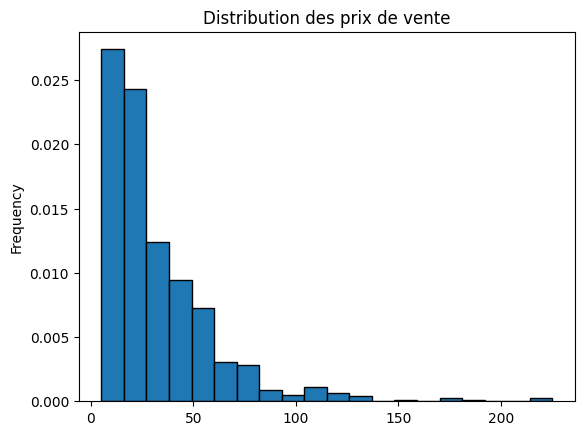

In [61]:
ax = df_final['price'].plot(kind='hist', density=True, bins=20,
                            edgecolor='black', title='Distribution des prix de vente')

del ax

On remarque qu'il n'y a ni prix négatifs, ni prix à 0. Les fréquences les plus importantes se retrouvent sur une plage de prix en dessous de 50 € mais on observe qu'il y a plusieurs prix atypiques pouvant être supérieurs à 200 €.

### Mesures de tendance centrale<a id='4-2'></a>

Afin d'avoir une idée de la valeur autour de laquelle se concentrent les prix, calculons le mode, la moyenne et la médiane.

In [62]:
price_mode = df_final['price'].mode()
price_mean = df_final['price'].mean()
price_median = df_final['price'].median()

print(
    f'Mode : {price_mode}\nMoyenne : {price_mean:.2f}\nMédiane : {price_median}')

del price_mode, price_mean, price_median

Mode : 0    19.0
Name: price, dtype: float64
Moyenne : 32.49
Médiane : 23.55


Le **mode** nous indique que **19 €** est le prix qui revient le plus souvent. La **moyenne**, à **32,49 €**, n'est pas vraiment exploitable car elle tient compte des valeurs aberrantes de notre jeu de données. La **médiane**, quant à elle, nous indique que la moitié des prix sont supérieurs à **23,55 €**.<br>
Le fait que la moyenne soit supérieure à la médiane montre, tout comme l'histogramme, qu'il y a des valeurs aberrantes dans le jeu de données.

### Mesures de dispersion<a id='4-3'></a>

Pour analyser plus en détail ces valeurs atypiques, calculons les mesures de dispersion. Elles vont nous permettre de préciser la façon dont les prix se répartissent autour des mesures de tendance centrale.<br>
Commençons par l'étendue en affichant les valeurs extrêmes.

In [63]:
price_mini = df_final['price'].min()
price_maxi = df_final['price'].max()

print(f'Les prix s\'étendent de : {price_mini} € à {price_maxi} €.')

del price_mini, price_maxi

Les prix s'étendent de : 5.2 € à 225.0 €.


On constate encore une fois que les valeurs supérieures aux valeurs centrales sont bien plus étendues que celles qui sont inférieures.<br>
Voyons aussi comment se répartissent les prix autour des valeurs centrales grâce à la variance et l'écart-type. Ce sont les valeurs non biaisées de ces indicateurs qui seront calculées.

In [64]:
variance = df_final['price'].var(ddof=0)
ecart_type = df_final['price'].std(ddof=0)

print(f'Variance : {variance:.2f}\nEcart-type : {ecart_type:.2f}')

del variance, ecart_type

Variance : 772.34
Ecart-type : 27.79


La variance est difficilement interprétable car elle n'est pas dans la même unité que nos données. L'écart-type, avec une valeur proche de la moyenne, permet de constater une nouvelle fois que les prix sont assez dispersés autour de cette dernière.<br>
Traçons une représentation graphique de type boîte à moustaches pour finalement identifier les valeurs aberrantes.

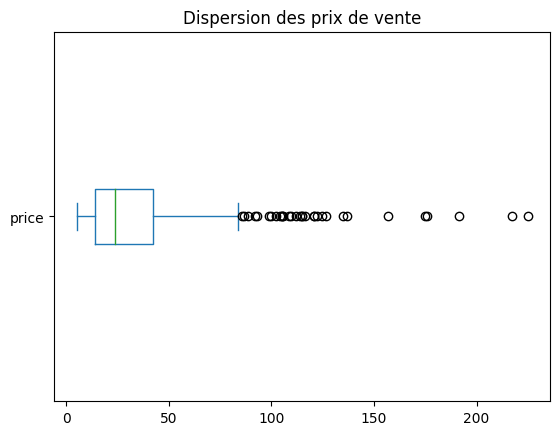

In [65]:
ax = (df_final['price'].plot(kind='box', vert=False,
                             title='Dispersion des prix de vente'))

del ax

Cette fois on voit très clairement nos *outliers* et où ils se situent. Nous allons afficher les produits qui se situent entre la borne maximale de la boîte à moustaches et la valeurs maximale des données.
La borne maximale du *boxplot* se calcule de la manière suivante:<br><br>
$max\_boxplot = 1,5 * IQR + Q_3$<br>
avec:<br>
$IQR = Q_3 - Q_1$<br>
$Q_1 = premier\ quartile$<br>
$Q_3 = troisième\ quartile$

In [66]:
# Calcul de la borne maximale
Q1, Q3 = df_final['price'].quantile(0.25), df_final['price'].quantile(0.75)
IQR = Q3 - Q1
max_boxplot = 1.5 * IQR + Q3

# Affichage des 15 outliers avec les prix les plus élevés
df_final.loc[(df_final['price'] >= max_boxplot)
             & (df_final['price'] <= df_final['price'].max())
             ].nlargest(15, 'price')

,product_id,post_title,post_date,post_modified,onsale_web,sku,stock_quantity,stock_status,price,total_sales,turnover,%_turnover
199,4352,Champagne Egly-Ouriet Grand Cru Millésimé 2008,2018-03-02,2020-03-07,True,15940,0,outofstock,225.0,5.0,1125.0,0.015942
426,5001,David Duband Charmes-Chambertin Grand Cru 2014,2018-07-17,2020-05-16,True,14581,20,instock,217.5,0.0,0.0,0.000000
587,5892,Coteaux Champenois Egly-Ouriet Ambonnay Rouge ...,2019-03-28,2020-04-01,True,14983,10,instock,191.3,3.0,573.9,0.008133
218,4402,Cognac Frapin VIP XO,2018-03-22,2020-08-22,True,3510,8,instock,176.0,13.0,2288.0,0.032422
553,5767,Camille Giroud Clos de Vougeot 2016,2019-03-13,2020-06-11,True,15185,12,instock,175.0,0.0,0.0,0.000000
221,4406,Cognac Frapin Château de Fontpinot 1989 20 Ans...,2018-03-22,2020-03-14,True,7819,3,instock,157.0,0.0,0.0,0.000000
381,4904,Domaine Des Croix Corton Charlemagne Grand Cru...,2018-05-15,2020-05-19,True,14220,13,instock,137.0,5.0,685.0,0.009707
642,6126,Champagne Gosset Célébris Vintage 2007,2019-06-28,2020-08-27,True,14923,10,instock,135.0,2.0,270.0,0.003826
201,4355,Champagne Egly-Ouriet Grand Cru Blanc de Noirs,2018-03-02,2020-08-13,True,12589,2,instock,126.5,11.0,1391.5,0.019718
511,5612,Domaine Weinbach Gewurztraminer Grand Cru Furs...,2019-01-15,2019-01-23,True,14915,12,instock,124.8,0.0,0.0,0.000000


In [67]:
del Q1, Q3, IQR, max_boxplot

### Conclusion<a id='4-4'></a>

Les prix qui correspondent aux valeurs les plus aberrantes concernent principalement des 1er crus ou des grands crus sur des millésimes assez anciens. On retrouve également du cognac ou encore du whisky. Il semble finalement assez logique que leurs prix soient bien plus élevés que le reste des autres produits mais **ils ne constituent en rien des erreurs**.

## Pour aller plus loin<a id='5'></a>

### Mesures de forme<a id='5-1'></a>

Une autre façon d'appréhender la distribution de nos prix aurait pu être d'étudier l'asymétrie et l'aplatissement de nos données grâce au Skewness empirique et au Kurtosis empirique.

In [68]:
price_skew = df_final['price'].skew()
price_kurt = df_final['price'].kurtosis()

print(f'Skewness : {price_skew:.2f}\nKurtosis : {price_kurt:.2f}')

del price_skew, price_kurt

Skewness : 2.58
Kurtosis : 10.09


Le skewness montre que la distribution est asymétrique et qu'elle est étalée à droite car sa valeur est positive.<br>
Ici, le kurtosis ne pourra pas nous donner beaucoup d'indications car l'aplatissement ne peut s'interpréter qu'à condition que la distribution soit symétrique.

### Mesures de concentration<a id='5-2'></a>

Pour terminer, revenons au chiffre d'affaires en étudions sa concentration. Cela va nous permettre de vérifier si le chiffre d'affaires est réparti de manière égalitaire entre les produits. Cela revient à voir quel pourcentage de chiffre d'affaires et généré par quel pourcentage de produits. Pour cela, nous allons tracer la courbe de Lorenz.

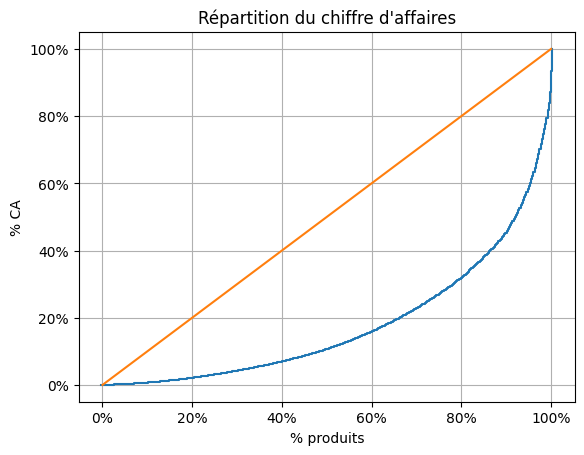

In [69]:
# Données du graphique
# Sélection des valeurs de CA > 0
turnover = df_final.loc[df_final['turnover'] > 0, 'turnover']
# Calcul nombre de valeurs
n_turnover = len(turnover)

# Calcul CA (tri croissant) cumulé et normalisé (max = 1)
cum_turnover = np.cumsum(np.sort(turnover)) / turnover.sum()
# Ajout 0 car la courbe commence à 0
cum_turnover = np.append([0], cum_turnover)

# Calcul cumul nombre de produits
cum_product = np.linspace(0-1/n_turnover, 1+1/n_turnover,
                                 len(cum_turnover))

# Configuration et traçage graphique
fig, ax = plt.subplots()

ax.plot(cum_product, cum_turnover, drawstyle='steps-post')
ax.plot([0, 1], [0, 1])

ax.grid(True)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))

ax.set_title('Répartition du chiffre d\'affaires')
ax.set_xlabel('% produits')
ax.set_ylabel('% CA')

plt.show()

del fig, ax

On observe facilement que la répartition n'est pas égalitaire. Une des lectures de cette courbe pourrait être: **50 % du chiffre d'affaires** est réalisé par **&#0177;10 % des produits**. Cela tend à rejoindre le constat que nous avions fait lors de l'affichage du [chiffre d'affaires par produit](#3-1).<br>
En fin, résumons cette courbe en calculant l'indice de Gini.

In [70]:
# Surface sous la courbe de Lorenz.
# Le premier segment (cum_turnover[0]) est à moitié en dessous de 0, on le coupe donc en 2.
# On fait de même pour le dernier segment cum_turnover[-1] qui est à moitié au-dessus de 1.
AUC = (cum_turnover.sum() -
       cum_turnover[-1] / 2 - cum_turnover[0] / 2) / n_turnover

# Surface entre la première bissectrice et la courbe de Lorenz
S = 0.5 - AUC

# Gini
turnover_gini = 2 * S
print(f'Indice de Gini : {turnover_gini:.2f}')

del turnover, n_turnover, cum_turnover, cum_product, AUC, S, turnover_gini

Indice de Gini : 0.64


Un indice nul montre une égalité parfaite et un indice égal à 1 montre une inégalité parfaite. Avec une valeur de 0,64, la répartition du chiffre d'affaires est plutôt inégalitaire. Il pourrait par exemple être intéressant de suivre son évolution au cours du temps mais cela n'est pas possible dans notre cas.